In [ ]:
%matplotlib inline


# Comparison of LSTM with different transformations


In [1]:

from ai4water.models import LSTM
from ai4water.utils.utils import get_version_info
from ai4water.experiments import TransformationExperiments
from ai4water.hyperopt import Categorical, Integer
from ai4water.utils.utils import dateandtime_now

from ai4water.datasets import MtropicsLaos


D:\C\Anaconda3\envs\tfcpu27_py39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\C\Anaconda3\envs\tfcpu27_py39\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
D:\C\Anaconda3\envs\tfcpu27_py39\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
D:\C\Anaconda3\envs\tfcpu27_py39\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [2]:

for k,v in get_version_info().items():
    print(f"{k} version: {v}")

python version: 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:20:16) [MSC v.1916 64 bit (AMD64)]
os version: nt
ai4water version: 1.06
lightgbm version: 3.3.1
tcn version: 3.4.0
catboost version: 0.26
xgboost version: 1.5.0
easy_mpl version: 0.21.2
SeqMetrics version: 1.3.3
tensorflow version: 2.7.0
keras.api._v2.keras version: 2.7.0
numpy version: 1.21.0
pandas version: 1.3.4
matplotlib version: 3.4.3
h5py version: 3.5.0
sklearn version: 1.0.1
shapefile version: 2.3.0
xarray version: 0.20.1
netCDF4 version: 1.5.7
optuna version: 2.10.1
skopt version: 0.9.0
hyperopt version: 0.2.7
plotly version: 5.3.1
lime version: NotDefined
seaborn version: 0.11.2


In [3]:
dataset = MtropicsLaos(save_as_nc=True,  # if set to True, then netcdf must be installed
                       convert_to_csv=False,
                       path="F:\\data\\MtropicsLaos",  # path where the data is saved, if not availble leave it to None
                      )


    Not downloading the data since the directory 
    F:\data\MtropicsLaos already exists.
    Use overwrite=True to remove previously saved files and download again


In [6]:
lookback = 18
data =    dataset.make_regression(lookback_steps=lookback)

print(data.shape)

Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.


(3691, 9)


In [7]:
data.head()

,air_temp,rel_hum,wind_speed,sol_rad,water_level,pcp,susp_pm,Ecoli_source,Ecoli_mpn100
2011-05-25 14:54:00,22.538134,96.169885,4.3,167.8,133.000000,0.0,0.9,2.868160e+15,NaN
2011-05-25 15:00:00,22.538271,96.170115,4.0,158.0,133.000000,0.0,0.9,2.868160e+15,NaN
2011-05-25 15:06:00,22.538407,96.170345,3.7,150.0,133.000000,0.0,0.9,2.868160e+15,NaN
2011-05-25 15:12:00,22.538544,96.170575,3.4,142.0,132.988889,0.0,0.9,2.868160e+15,NaN
2011-05-25 15:18:00,22.538680,96.170805,3.1,134.0,132.977778,0.0,0.9,2.868160e+15,NaN


In [8]:
print(data.isna().sum())

air_temp           0
rel_hum            0
wind_speed         0
sol_rad            0
water_level        0
pcp                0
susp_pm            0
Ecoli_source       0
Ecoli_mpn100    3433
dtype: int64


In [15]:
input_features = data.columns.tolist()[0:-1]
input_features

['air_temp',
 'rel_hum',
 'wind_speed',
 'sol_rad',
 'water_level',
 'pcp',
 'susp_pm',
 'Ecoli_source']

In [16]:
output_features = data.columns.tolist()[-1:]
output_features

['Ecoli_mpn100']

In [17]:
class MyTransformationExperiments(TransformationExperiments):

    def update_paras(self, **kwargs):
        _layers = LSTM(units=kwargs['units'],
                       input_shape=(lookback, len(input_features)),
                       activation=kwargs['activation'])

        y_transformation = kwargs['y_transformation']
        if y_transformation == "none":
            y_transformation = None

        return {
            'model': _layers,
            'batch_size': int(kwargs['batch_size']),
            'lr': float(kwargs['lr']),
            'y_transformation': y_transformation
        }

In [18]:
cases = {
    'model_None': {'y_transformation': 'none'},
    'model_minmax': {'y_transformation': 'minmax'},
    'model_zscore': {'y_transformation': 'zscore'},
    'model_robust': {'y_transformation': 'robust'},
    'model_quantile': {'y_transformation': 'quantile'},
    'model_log': {'y_transformation': {'method':'log', 'treat_negatives': True, 'replace_zeros': True}},
    "model_pareto": {"y_transformation": "pareto"},
    "model_vast": {"y_transformation": "vast"},
    "model_mmad": {"y_transformation": "mmad"},
    'model_box_cox': {'y_transformation': {'method': 'box-cox', 'treat_negatives': True, 'replace_zeros': True}},
    'model_yeo-johnson': {'y_transformation': 'yeo-johnson'},
         }

In [19]:
search_space = [
    Integer(low=10, high=30, name='units', num_samples=10),
    Categorical(categories=['relu', 'elu', 'tanh', "linear"], name='activation'),
    Categorical(categories=[4, 8, 12, 16, 24, 32], name='batch_size'),
    Categorical(categories=[0.05, 0.02, 0.009, 0.007, 0.005,
                            0.003, 0.001, 0.0009, 0.0007, 0.0005, 0.0003,
                            0.0001, 0.00009, 0.00007, 0.00005], name='lr'),
]

In [20]:
x0 = [16, "relu", 32, 0.0001]

experiment = MyTransformationExperiments(
    x_transformation="minmax",
    cases=cases,
    input_features=input_features,
    output_features = output_features,
    param_space=search_space,
    x0=x0,
    verbosity=0,
    epochs=500,
    exp_name = f"ecoli_lstm_y_exp_{dateandtime_now()}",
    ts_args={"lookback": lookback},
    save=False
)

In [21]:
experiment.fit(data = data,  run_type='dry_run')


********** Removing Examples with nan in labels  **********

***** Training *****
input_x shape:  (144, 18, 8)
target shape:  (144, 1)

********** Removing Examples with nan in labels  **********

***** Validation *****
input_x shape:  (36, 18, 8)
target shape:  (36, 1)

********** Removing Examples with nan in labels  **********

***** Test *****
input_x shape:  (78, 18, 8)
target shape:  (78, 1)
running  None model
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)


divide by zero encountered in true_divide
divide by zero encountered in log
divide by zero encountered in true_divide


running  minmax model
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)


divide by zero encountered in true_divide
divide by zero encountered in log
invalid value encountered in log
invalid value encountered in log
divide by zero encountered in true_divide


running  zscore model
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)


divide by zero encountered in true_divide
divide by zero encountered in log
invalid value encountered in log
invalid value encountered in log
divide by zero encountered in true_divide


running  robust model
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)


divide by zero encountered in true_divide
divide by zero encountered in log
invalid value encountered in log
invalid value encountered in log
divide by zero encountered in true_divide


running  quantile model
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)


divide by zero encountered in true_divide
divide by zero encountered in log
divide by zero encountered in true_divide


running  log model
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)


overflow encountered in square
overflow encountered in reduce


running  pareto model
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)


divide by zero encountered in true_divide
divide by zero encountered in log
invalid value encountered in log
invalid value encountered in log
divide by zero encountered in true_divide


running  vast model
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)


invalid value encountered in log
invalid value encountered in log


running  mmad model
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)


divide by zero encountered in true_divide
divide by zero encountered in log
divide by zero encountered in true_divide


running  box_cox model


overflow encountered in power
overflow encountered in multiply
overflow encountered in reduce


assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
running  yeo-johnson model


overflow encountered in power
overflow encountered in multiply
overflow encountered in reduce


assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)


divide by zero encountered in true_divide
divide by zero encountered in log
divide by zero encountered in true_divide



********** Removing Examples with nan in labels  **********

***** Training *****
input_x shape:  (144, 18, 8)
target shape:  (144, 1)

********** Removing Examples with nan in labels  **********

***** Validation *****
input_x shape:  (36, 18, 8)
target shape:  (36, 1)

********** Removing Examples with nan in labels  **********

***** Test *****
input_x shape:  (78, 18, 8)
target shape:  (78, 1)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)


overflow encountered in multiply
overflow encountered in square
overflow encountered in square
overflow encountered in square
overflow encountered in square


assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)


divide by zero encountered in true_divide


assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)


divide by zero encountered in true_divide


assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)


divide by zero encountered in true_divide


assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)


divide by zero encountered in true_divide


assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)


divide by zero encountered in true_divide


assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)


divide by zero encountered in true_divide


assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)


divide by zero encountered in true_divide


assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)


divide by zero encountered in true_divide


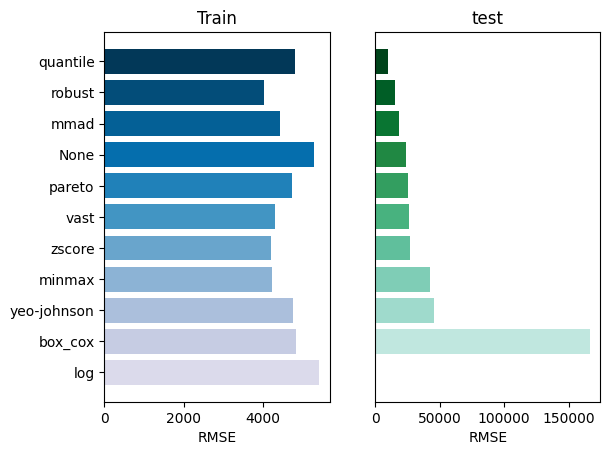

In [23]:
results = experiment.compare_errors('rmse', data=data)

In [24]:
print(results)

                   train          test
log          5409.450619           inf
box_cox      4814.439939  1.662770e+05
yeo-johnson  4757.606795  4.553616e+04
minmax       4226.970310  4.295539e+04
zscore       4187.136969  2.706149e+04
vast         4300.321445  2.651358e+04
pareto       4736.278899  2.515788e+04
None         5282.584216  2.427799e+04
mmad         4424.704330  1.870424e+04
robust       4014.077852  1.541642e+04
quantile     4798.453918  1.030005e+04



********** Removing Examples with nan in labels  **********

***** Training *****
input_x shape:  (144, 18, 8)
target shape:  (144, 1)

********** Removing Examples with nan in labels  **********

***** Validation *****
input_x shape:  (36, 18, 8)
target shape:  (36, 1)

********** Removing Examples with nan in labels  **********

***** Test *****
input_x shape:  (78, 18, 8)
target shape:  (78, 1)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)


overflow encountered in multiply
overflow encountered in square
overflow encountered in square
overflow encountered in square
overflow encountered in square


assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)


divide by zero encountered in true_divide


assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)


divide by zero encountered in true_divide


assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)


divide by zero encountered in true_divide


assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)


divide by zero encountered in true_divide


assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)


divide by zero encountered in true_divide


assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)


divide by zero encountered in true_divide


assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)


divide by zero encountered in true_divide


assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)


divide by zero encountered in true_divide


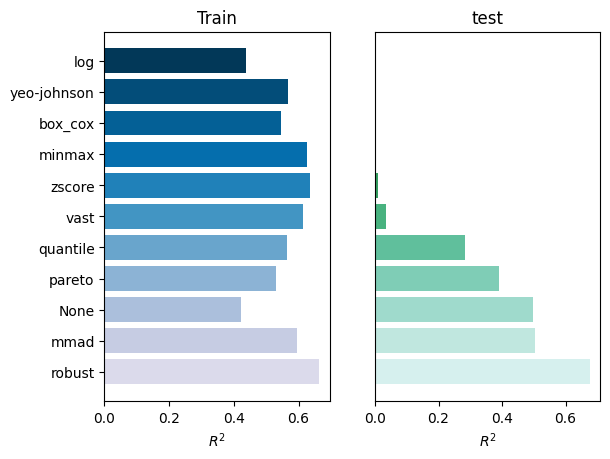

In [25]:
r_squares = experiment.compare_errors('r2', data=data)

In [26]:
print(r_squares)

                train      test
robust       0.663870  0.676143
mmad         0.594767  0.504128
None         0.423291  0.498426
pareto       0.531722  0.389125
quantile     0.565400  0.281959
vast         0.614166  0.035123
zscore       0.634722  0.007834
minmax       0.626898  0.001608
box_cox      0.547313  0.000283
yeo-johnson  0.567264  0.000166
log          0.438190  0.000000



********** Removing Examples with nan in labels  **********

***** Training *****
input_x shape:  (144, 18, 8)
target shape:  (144, 1)

********** Removing Examples with nan in labels  **********

***** Validation *****
input_x shape:  (36, 18, 8)
target shape:  (36, 1)

********** Removing Examples with nan in labels  **********

***** Test *****
input_x shape:  (78, 18, 8)
target shape:  (78, 1)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)


overflow encountered in multiply
overflow encountered in square
overflow encountered in square
overflow encountered in square
overflow encountered in square


assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)


divide by zero encountered in true_divide


assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)


divide by zero encountered in true_divide


assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)


divide by zero encountered in true_divide


assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)


divide by zero encountered in true_divide


assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)


divide by zero encountered in true_divide


assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)


divide by zero encountered in true_divide


assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)


divide by zero encountered in true_divide


assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)


divide by zero encountered in true_divide


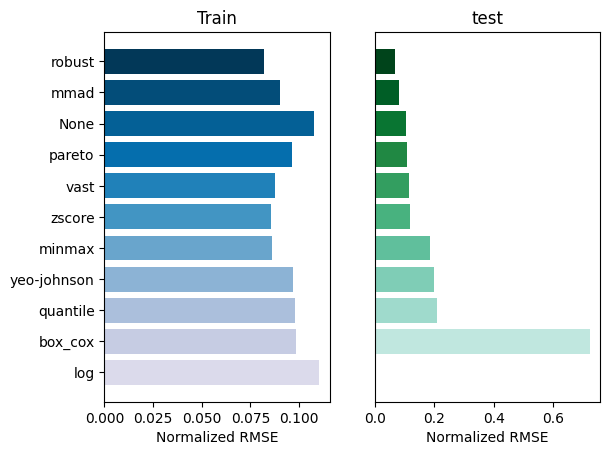

In [27]:
nrmses = experiment.compare_errors('nrmse', data=data)

In [28]:
print(nrmses)

                train      test
log          0.110399       inf
box_cox      0.098330  0.723063
quantile     0.097928  0.210205
yeo-johnson  0.097094  0.197983
minmax       0.086265  0.186763
zscore       0.085452  0.117659
vast         0.087762  0.115276
pareto       0.096659  0.109382
None         0.107808  0.105556
mmad         0.090300  0.081323
robust       0.081920  0.067028



********** Removing Examples with nan in labels  **********

***** Training *****
input_x shape:  (144, 18, 8)
target shape:  (144, 1)

********** Removing Examples with nan in labels  **********

***** Validation *****
input_x shape:  (36, 18, 8)
target shape:  (36, 1)

********** Removing Examples with nan in labels  **********

***** Test *****
input_x shape:  (78, 18, 8)
target shape:  (78, 1)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)


overflow encountered in multiply
overflow encountered in square
overflow encountered in square
overflow encountered in square
overflow encountered in square


assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)


divide by zero encountered in true_divide


assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)


divide by zero encountered in true_divide


assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)


divide by zero encountered in true_divide


assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)


divide by zero encountered in true_divide


assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)


divide by zero encountered in true_divide


assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)


divide by zero encountered in true_divide


assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)


divide by zero encountered in true_divide


assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)


divide by zero encountered in true_divide


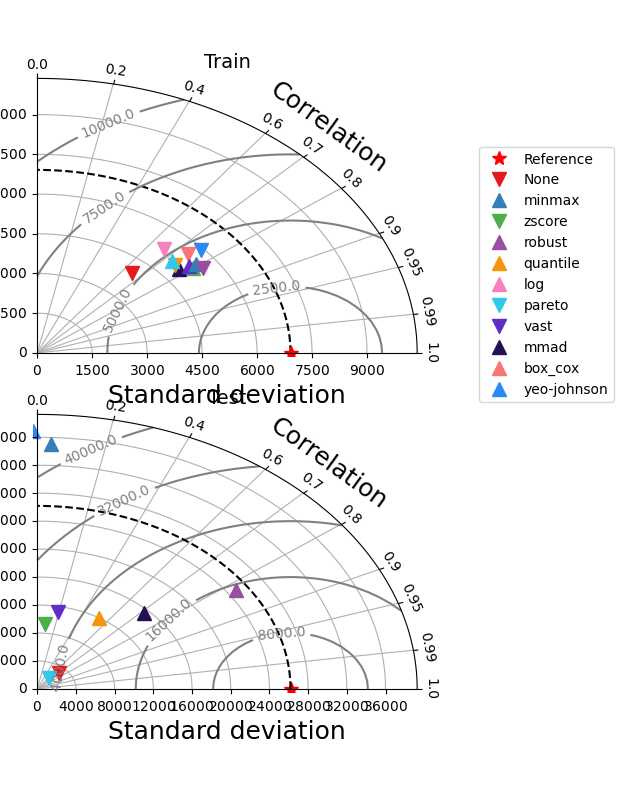

In [31]:
_ = experiment.taylor_plot(data=data, figsize=(5, 8), leg_kws=dict(bbox_to_anchor=(1.3, 0.8)))


********** Removing Examples with nan in labels  **********

***** Training *****
input_x shape:  (144, 18, 8)
target shape:  (144, 1)

********** Removing Examples with nan in labels  **********

***** Validation *****
input_x shape:  (36, 18, 8)
target shape:  (36, 1)

********** Removing Examples with nan in labels  **********

***** Test *****
input_x shape:  (78, 18, 8)
target shape:  (78, 1)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
assigning name Input to IteratorGetNext:0 with shape (None, 18

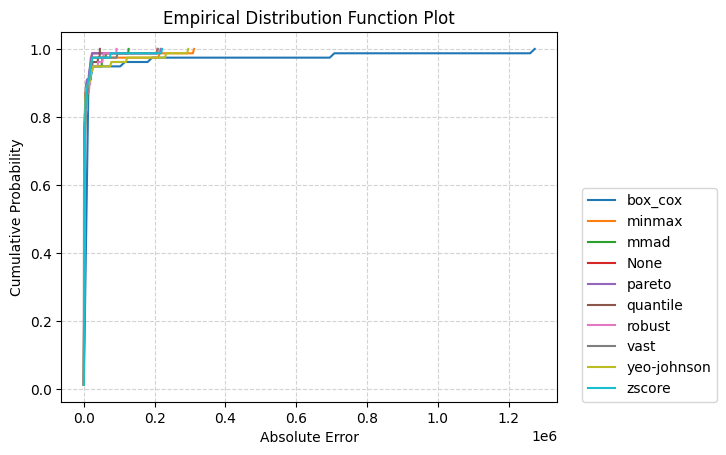

In [37]:
_ = experiment.compare_edf_plots(data=data, exclude=["log"])


********** Removing Examples with nan in labels  **********

***** Training *****
input_x shape:  (144, 18, 8)
target shape:  (144, 1)

********** Removing Examples with nan in labels  **********

***** Validation *****
input_x shape:  (36, 18, 8)
target shape:  (36, 1)

********** Removing Examples with nan in labels  **********

***** Test *****
input_x shape:  (78, 18, 8)
target shape:  (78, 1)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
assigning name Input to IteratorGetNext:0 with shape (None, 18

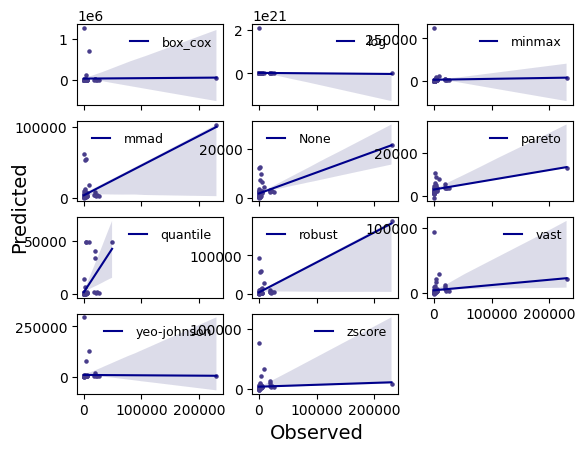

In [42]:
_ = experiment.compare_regression_plots(data=data)


********** Removing Examples with nan in labels  **********

***** Training *****
input_x shape:  (144, 18, 8)
target shape:  (144, 1)

********** Removing Examples with nan in labels  **********

***** Validation *****
input_x shape:  (36, 18, 8)
target shape:  (36, 1)

********** Removing Examples with nan in labels  **********

***** Test *****
input_x shape:  (78, 18, 8)
target shape:  (78, 1)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
assigning name Input to IteratorGetNext:0 with shape (None, 18, 8)
assigning name Input to IteratorGetNext:0 with shape (None, 18

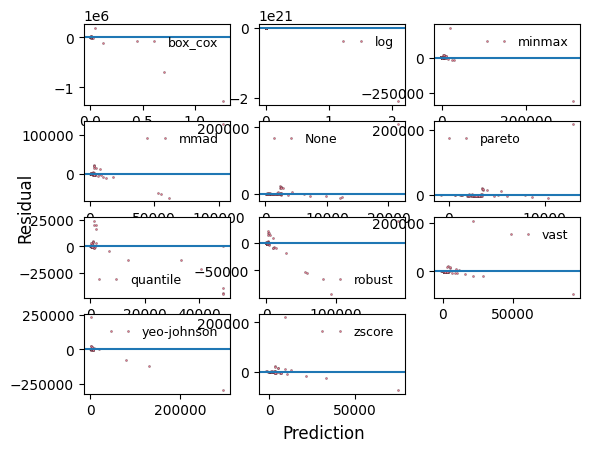

In [41]:
_ = experiment.compare_residual_plots(data=data)

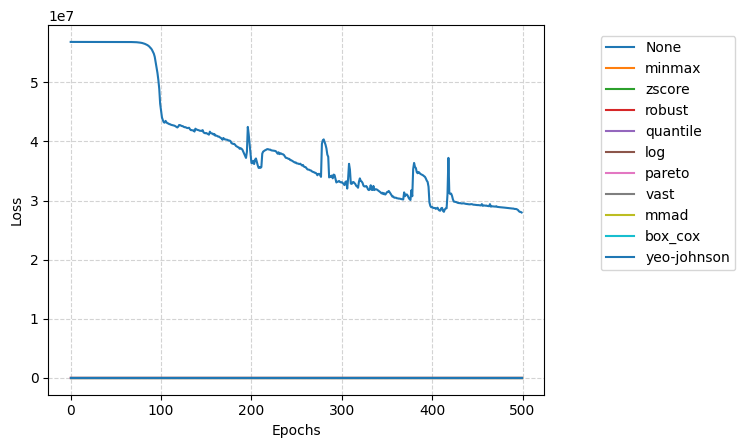

In [40]:
_ = experiment.loss_comparison()